In [1]:
pip install numpy tensorflow scikit-learn

  Using cached tensorflow-2.18.0-cp310-cp310-win_amd64.whl (7.5 kB)
  Using cached tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl (390.0 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Gigabyte\.pyenv\pyenv-win\versions\3.10.0\python.exe -m pip install --upgrade pip' command.


In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 26

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,866 (65.88 KB)

 Trainable params: 16,782 (65.55 KB)

 Non-trainable params: 84 (336.00 B)

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
193/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1335 - loss: 4.4694
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1386 - loss: 4.4100 - val_accuracy: 0.2670 - val_loss: 3.0997
Epoch 2/1000
211/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2701 - loss: 2.9315
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2704 - loss: 2.9290 - val_accuracy: 0.3551 - val_loss: 2.4399
Epoch 3/1000
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3209 - loss: 2.5327
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3209 - loss: 2.5326 - val_accuracy: 0.4108 - val_loss: 2.2548
Epoch 4/1000
188/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3475 - loss: 2.4265
Epoch 4: saving model to model/keypoint_classifier/keypoint_classi

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.7671


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[2.3826589e-03 3.7381866e-08 9.1269726e-08 8.1678974e-07 1.7587726e-06
 6.3355524e-06 3.7288493e-05 9.8738151e-10 1.8291125e-03 8.1547600e-04
 2.9250412e-05 2.1054431e-04 9.6018084e-06 4.5068461e-07 1.1795287e-05
 2.5977856e-08 7.3759814e-08 7.5944234e-10 8.7908102e-06 3.8755045e-04
 1.6563371e-09 2.6027751e-08 1.0909880e-06 2.3848890e-05 9.9423474e-01
 8.6024502e-06]
24


# Confusion matrix

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


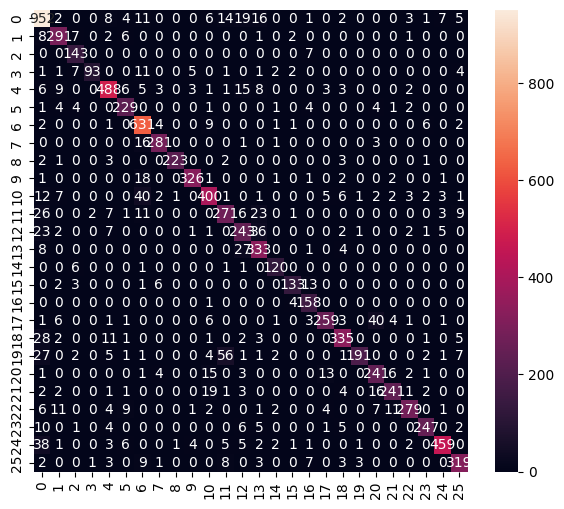

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1051
           1       0.85      0.92      0.88       318
           2       0.83      0.95      0.89       150
           3       0.97      0.73      0.83       128
           4       0.89      0.88      0.89       553
           5       0.86      0.91      0.89       251
           6       0.83      0.96      0.89       657
           7       0.93      0.93      0.93       302
           8       0.99      0.95      0.97       235
           9       0.96      0.92      0.94       353
          10       0.86      0.82      0.84       489
          11       0.75      0.75      0.75       360
          12       0.73      0.75      0.74       324
          13       0.77      0.89      0.83       373
          14       0.90      0.93      0.92       129
          15       0.92      0.84      0.88       158
          16       0.81      0.97      0.88       163
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [24]:

model.save(model_save_path)

In [18]:


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Gigabyte\AppData\Local\Temp\tmpttprfalx\assets


INFO:tensorflow:Assets written to: C:\Users\Gigabyte\AppData\Local\Temp\tmpttprfalx\assets


Saved artifact at 'C:\Users\Gigabyte\AppData\Local\Temp\tmpttprfalx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  1850972387136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850991646096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850935401408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850972381680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850991641872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850934391760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1850991507088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1851060919408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1851060922048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1851060925216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18510609271

27696

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.3866335e-03 3.7134587e-08 9.0141278e-08 8.1794860e-07 1.7407037e-06
 6.5056788e-06 3.8053604e-05 1.0072464e-09 1.7459451e-03 8.1825373e-04
 3.0101617e-05 2.0335348e-04 9.4494544e-06 4.4188567e-07 1.1737953e-05
 2.4878679e-08 7.3093922e-08 7.6350076e-10 8.9748064e-06 3.7624888e-04
 1.6717440e-09 2.6551801e-08 1.1059100e-06 2.3468911e-05 9.9432832e-01
 8.5842048e-06]
24
